In [47]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from stock_data import training_gen

import matplotlib.pyplot as plt

from tqdm import tqdm

import gym
import real_market_env_gym

In [48]:
model = nn.Sequential(
    nn.Linear(100, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 3),
    nn.Softmax(dim=0)
)

In [51]:
def input_handler(x, y):
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    mean = x.mean()
    std = x.std()

    actions = [y > x[-1], y == x[-1], y < x[-1]]
    actions = torch.tensor(actions, dtype=torch.float32).T

    x = (x - mean) / std

    return x, actions, mean, std

In [53]:

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

losses = []

for epoch in range(10):
    MAX = 110000
    data_gen = training_gen(max_len=18)
    for i in tqdm(range(MAX), desc='Batch', position=0):
        try:
            x, y = next(data_gen)
            x, y, mean, std = input_handler(x, y)
            if np.isnan(y).any():
                print(f'NAN AT {i}')
        except StopIteration:
            print(f'STOPPED AT {i}')
            break


        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        # if i % (MAX // 1000) == 0:
        losses.append(loss.item())

losses = np.array(losses)


Batch:  99%|█████████▉| 109400/110000 [01:46<00:00, 1029.09it/s]


STOPPED AT 109400


Batch:  99%|█████████▉| 109400/110000 [01:45<00:00, 1040.20it/s]


STOPPED AT 109400


Batch:  99%|█████████▉| 109400/110000 [01:46<00:00, 1028.47it/s]


STOPPED AT 109400


Batch:  99%|█████████▉| 109400/110000 [01:41<00:00, 1082.89it/s]


STOPPED AT 109400


Batch:  99%|█████████▉| 109400/110000 [01:42<00:00, 1068.64it/s]


STOPPED AT 109400


Batch:  99%|█████████▉| 109400/110000 [01:44<00:00, 1042.32it/s]


STOPPED AT 109400


Batch:  99%|█████████▉| 109400/110000 [01:46<00:00, 1029.70it/s]


STOPPED AT 109400


Batch:  99%|█████████▉| 109400/110000 [01:45<00:00, 1033.79it/s]


STOPPED AT 109400


Batch:  99%|█████████▉| 109400/110000 [01:45<00:00, 1033.87it/s]


STOPPED AT 109400


Batch:  99%|█████████▉| 109400/110000 [01:45<00:00, 1035.49it/s]


STOPPED AT 109400


In [54]:
torch.save(model, 'log/policy_sup_single.pth')

In [59]:
env = gym.make('real_market_env_gym-v0')
env.reset()

model = torch.load('log/policy_sup_single.pth')

tests = 100
test_data = []

for i in tqdm(range(tests), desc='Test', position=0):
    for i in range(100):
        obs, _ = env.reset()
        done = False
        while not done:
            prices = (np.array(obs[:100]) - np.mean(obs[:100])) / np.std(obs[:100])
            action = int(model(torch.tensor(prices, dtype=torch.float32)).argmax().item())
            obs, reward, done, _, info = env.step(action)

    test_data.append(info['value'])

test_data = np.array(test_data) - 1000


/Users/varun/Library/Mobile Documents/com~apple~CloudDocs/fyp2/venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/varun/Library/Mobile Documents/com~apple~CloudDocs/fyp2/venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
Test: 100%|██████████| 100/100 [04:02<00:00,  2.42s/it]


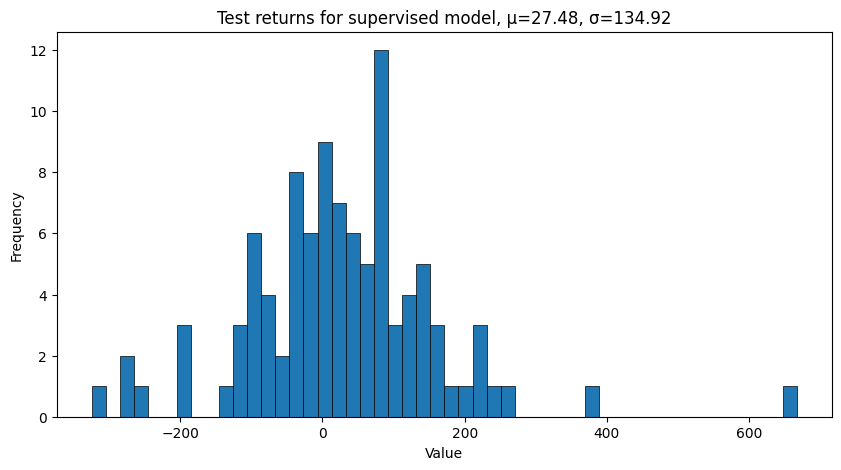

Dist 40|60


In [79]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.set_title(f'Test returns for supervised model, µ={test_data.mean():.2f}, σ={test_data.std():.2f}')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')

ax.hist(test_data, bins=50, edgecolor='black', linewidth=0.5)
plt.show()

print(f'Dist {len(test_data[test_data < 0])}|{len(test_data[test_data > 0])}')

tensor([115., 176., 115., 167., 146., 142., 115., 149., 182., 151.])
tensor([0.2462, 0.3768, 0.2462, 0.3576, 0.3126, 0.3040, 0.2462, 0.3190, 0.3897,
        0.3233])
